## Import Packages

1. To build a recurrent neural network, we start by importing the Dense layer, Activation layer, and Loss function that you implemented in Lab4 & Flatten layer you implemented in Lab5. Ensure the following three files are located in the same directory as this notebook, and follow the instructions to complete the setup:
    - Dense.py : Copy the **Dense class** you had implemented in Lab4 to it.
    - Activation.py : Copy the **Activation class** you had implemented in Lab4 to it.
    - Loss.py : Copy **compute_CCE_loss** function you had implemented in Lab4 to it.
    - Flatten.py: Copy **Flatten class** you had implemented in Lab5 to it.\
    Note: you should copy both `forward()` and `backward()` in class `Flatten` in Lab5.


⚠️ **WARNING** ⚠️:
*   Please do not import any other packages in this lab.
*   np.random.seed(seed) is used to keep all the random function calls consistent. It will help us grade your work. Please don't change the seed.

❗ **Important** ❗: Please do not change the code outside this code bracket.
```
### START CODE HERE ###
...
### END CODE HERE ###
```



### Mount Google Drive (optional)

In [ ]:
# ### START CODE HERE ###
# from google.colab import drive
# import os
# drive.mount('/content/drive')
# os.chdir('YOUR PATH')
# ### END CODE HERE ###

Mounted at /content/drive


In [3]:
###### import your Lab4 & Lab5 code (Don't change this part) ######
from Dense import Dense
from Activation import Activation
from Loss import compute_CCE_loss, compute_MSE_loss
from Flatten import Flatten
##################################

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd

outputs = {}

# Basic Part

## RNN Class (30%)
The RNN class implements a simple Recurrent Neural Network (RNN) layer. This class includes methods for initializing parameters, performing the forward pass, computing gradients during the backward pass, and updating the weights.

Structure overview:
<figure> <img src="https://imgur.com/nU7xrBe.png" width="580" height="400">
</figure>
RNN connection:
<figure>
<img src="https://imgur.com/4JQX0se.png" width="500" height="250">
</figure>
Data insights:
<figure> <img src="https://imgur.com/c2MI3mj.png" width="400" height="220">
</figure>
In each neuron:
<figure> <img src="https://imgur.com/luXS4zv.png" width="300" height="220">
</figure>

1.   **Initializaon**

    *   `input_size`: The number of input features for each time step.
    *   `rnn_units`: The number of units (neurons) in the RNN layer.
    *   `seed`: A random seed for weight initialization to ensure reproducibility.

2.   **Initialize parameters** (3%)
    * `Wx`: The weight matrix for the input to hidden connections. It has a shape of `(rnn_units, input_size)`
    * `Wh`: The weight matrix for the hidden to hidden connections. It has a shape of `(rnn_units, rnn_units)`
    * `bh`: The bias vector for the hidden state. It has a shape of `(rnn_units, 1)`, where rnn_units is the number of units in the RNN layer.
3.  **Forward** (12%) \
* `X`: Input data of shape `(batch_size, timesteps, input_size)`
* The forward pass computes the hidden state `h_t` (shape of `(batch_size, self.rnn_units)`)at each time step `t` using the following formula:
$ h_t = \tanh(W_x \cdot x_t + W_h \cdot h_{t-1} + b_h)$
    * $W_x$ is the weight matrix for the input to hidden connections.
    * $W_h$ is the weight matrix for the hidden to hidden connections.
    * $b_h$ is the bias vector.
    * $x_t$ is the input at time step t.
    * $h_{t-1}$ is the hidden state from the previous time step.
    * $\tanh$ is the hyperbolic tangent activation function.
* Output would be shape of `(batch_size, rnn_units)`
4. **Backward** (15%) \
Reference (Backpropagation Through Time):
https://www.pycodemates.com/2023/08/backpropagation-through-time-explained-with-derivations.html
* `dH`: Gradient of the loss with respect to the hidden state, typically of shape `(batch_size, rnn_units, 1)`.
* The backward pass computes the gradients of the loss with respect to the weights and biases using the following formulas:
    * Gradient of the loss with respect to the hidden state(derivative of `tanh`):\
    $\delta_t = (1 - h_t^2) \cdot \delta_{t+1}$
        * $\delta_t$ is the gradient of the loss with respect to the hidden state at time step t.
        * $h_t$ is the hidden state at time step t
    * Gradients with respect to the weights and biases (accumulate the gradients over all time steps):
        1. $\frac{\partial L}{\partial W_x} = ∑_{t=0}^{timesteps} \delta_t^T \cdot x_t$
        2. $\frac{\partial L}{\partial W_h} = ∑_ {t=0}^{timesteps} \delta_t^T \cdot h_{t-1}$
        3. $\frac{\partial L}{\partial b_h} = ∑_{t=0}^{timesteps} \delta_t^T$
        * $\frac{\partial L}{\partial W_x}$ is the gradient of the loss with respect to the input to hidden weights.
        * $\frac{\partial L}{\partial W_h}$ is the gradient of the loss with respect to the hidden to hidden weights.
        * $\frac{\partial L}{\partial b_h}$ is the gradient of the loss with respect to the hidden bias.
        * $x_t$ is the input at time step t.
        * $h_{t-1}$ is the hidden state from the previous time step.
    * Gradient with respect to the previous hidden state:
    $\frac{\partial L}{\partial h_{t-1}} = \delta_t \cdot W_h$
    * Then divide each gradient by `batch_size`.
    * Gradient clipping (optional) is recommended in RNN since RNN rely on backpropagation through time where data might contain large timesteps and it might cause gradient explosion or vanishing. **Note**: You can't do gradient clipping in the function testing (`test_baward()`)


In [312]:
class RNN():
    def __init__(self, input_size, rnn_units, seed=1):
        """
        Initialize the SimpleRNN layer.

        Parameters:
        input_size (int): Number of input features.
        rnn_units (int): Number of units in the RNN layer.
        seed (int): Random seed for weight initialization.
        """
        self.input_size = input_size
        self.rnn_units = rnn_units
        self.seed = seed
        self.initialize_parameters()

    def initialize_parameters(self):
        """
        Initialize the weights and biases for the RNN layer.
        """
        np.random.seed(self.seed)

        ### START CODE HERE ###
        # Multiply by 0.01 is for testing reason.
        #print("units: ",self.rnn_units,"\ninput_size:",self.input_size)
        self.Wx = np.random.randn(self.rnn_units,self.input_size) * 0.01     # Input to hidden weights , with shape of (rnn_units, input_size).
        self.Wh = np.random.randn(self.rnn_units,self.rnn_units) * 0.01     # Hidden to hidden weights, with shape of (rnn_units, rnn_units).
        self.bh = np.zeros((self.rnn_units,1))     # Hidden bias, with shape of (rnn_units, 1).
        ### END CODE HERE ###

    def forward(self, X):
        """
        Perform the forward pass through the RNN layer.

        Parameters:
        X (ndarray): Input data of shape (batch_size, timesteps, input_size).

        Returns:
        ndarray: Output of the RNN layer (hidden state).
        """
        batch_size, timesteps, _ = X.shape
        ### START CODE HERE ###
        self.h = np.zeros((batch_size,self.rnn_units))       # Initialize hidden state, with shape of (batch_size, self.rnn_units).
        self.hs = []      # Store hidden states for backward pass, list of self.h.
        ### END CODE HERE ###

        self.xs = []  # Store inputs for backward pass

        for t in range(timesteps):
            ### START CODE HERE ###
            x_t = X[:,t,:]              # Get input at time step t for all data in X.
            self.xs.append(x_t)
            # h_t = \tanh(W_x * x_t + W_h * h_{t-1} + b_h)$
            wx = self.Wx
            wh = self.Wh
            bh = self.bh
            # print("wx=",wx.shape," xt=",x_t.shape," wh=",wh.shape," ht-1=",self.h.shape," bh=",bh.shape)
            self.h = np.tanh(x_t@wx.T + self.h@wh.T  + bh.T)           # Update hidden state according to the formula of h_t.
            # self.h = np.tanh(np.dot(x_t, self.Wx.T) + np.dot(self.h, self.Wh.T) + self.bh)
            self.hs.append(self.h)
            ### END CODE HERE ###

        return self.h


    def backward(self, dH):
        """
        Perform the backward pass through the RNN layer.

        Parameters:
        dH (ndarray): Gradient of the loss with respect to the hidden state.
        clip_value (float): Value to clip the gradients to prevent exploding gradients.

        Returns:
        ndarray: Gradient of the loss with respect to the input.
        """
        batch_size, _ = dH.shape
        ### START CODE HERE ###
        self.dL_dWx = np.zeros((self.rnn_units,self.input_size))         # Initialized with same shape as Wx.
        self.dL_dWh = np.zeros((self.rnn_units,self.rnn_units))         # Initialized with same shape as Wh.
        self.dL_dbh = np.zeros((self.rnn_units,1))        # Initialized with same shape as bh.
        ### END CODE HERE ###
        dL_dh = dH

        for t in reversed(range(len(self.hs))):
            x_t = self.xs[t]  # Get input at time step t
            h = self.hs[t]
            h_prev = self.hs[t-1] if t > 0 else np.zeros_like(h)
            ### START CODE HERE ###
            dL_dh_raw = (1 - h**2)*dL_dh     # Derivative of tanh
            # print("x_t=",x_t.shape," h=",h.shape," dL_dh_raw=",dL_dh_raw.shape)
            self.dL_dWx += dL_dh_raw.T @ x_t   # Gradient w.r.t. Wx
            self.dL_dWh += dL_dh_raw.T @ h_prev   # Gradient w.r.t. Wh
            # print(f"{self.dL_dbh.shape=}, {dL_dh_raw.shape=}")
            self.dL_dbh += np.sum(dL_dh_raw,axis=0,keepdims=True).T   # Gradient w.r.t. bh
            dL_dh = dL_dh_raw@self.Wh         # Gradient w.r.t. previous hidden state (Wh)
            ### END CODE HERE ###

        ### START CODE HERE ###
        # Average gradients over the batch.
        # print(f'b={batch_size}, {len(self.hs)}')
        self.dL_dWx = self.dL_dWx/batch_size
        self.dL_dWh = self.dL_dWh/batch_size
        self.dL_dbh = self.dL_dbh/batch_size
        ### END CODE HERE ###

        ### START CODE HERE ###
        # Gradient part (optional), you can't run this part while testing the backward function !!!
        clip_value = 2.0
        # Clip gradients to prevent exploding gradients
        np.clip(self.dL_dWx, -clip_value, clip_value, out=self.dL_dWx)
        np.clip(self.dL_dWh, -clip_value, clip_value, out=self.dL_dWh)
        np.clip(self.dL_dbh, -clip_value, clip_value, out=self.dL_dbh)
        ### END CODE HERE ###

        return dL_dh

    def update(self, learning_rate):
        """
        Update the weights and biases using the computed gradients.

        Parameters:
        learning_rate (float): Learning rate for weight updates.
        """
        ### START CODE HERE ###
        # Update each weights.
        self.Wx -= self.dL_dWx * learning_rate
        self.Wh -= self.dL_dWh * learning_rate
        self.bh -= self.dL_dbh * learning_rate
        ### END CODE HERE ###

### Functions testing


#### `initialize_parameter` function

In [143]:
def test_initialization(save_to_output = False):
    input_size = 5
    rnn_units = 3
    rnn = RNN(input_size, rnn_units)
    print("Wx shape:", rnn.Wx.shape)
    print("Wh shape:", rnn.Wh.shape)
    print("bh shape:", rnn.bh.shape)
    if save_to_output == True:
        outputs['RNN_initialization'] = {"Wx shape": rnn.Wx.shape, "Wh shape": rnn.Wh.shape, "bh shape": rnn.bh.shape}
test_initialization(True)

Wx shape: (3, 5)
Wh shape: (3, 3)
bh shape: (3, 1)


Expected output:

|Output|Value|
|---|---|
|Wx shape:|(3, 5)|
|Wh shape:|(3, 3)|
|bh shape:|(3, 1)|

#### `forward` function


In [159]:
def test_forward(seed, save_to_output = False):
    input_size = 5
    rnn_units = 3
    batch_size = 2
    timesteps = 4
    # Initialize the RNN layer
    rnn = RNN(input_size, rnn_units)
    # Create a sample input of shape (batch_size, timesteps, input_size)
    np.random.seed(seed)   # Don't change the seed!
    X = np.random.randn(batch_size, timesteps, input_size)
    # Perform the forward pass
    output = rnn.forward(X)

    if save_to_output == False:
        # Print the output
        print("Input shape:", X.shape)
        print("Input:")
        print(X)
        print("Output shape of RNN layer:", output.shape)
        print("Output of the RNN layer (hidden state):")
        print(output)

    if save_to_output == True:
        outputs['RNN_forward'] = {"X shape": X.shape, "X": X, "Output shape": output.shape, "Output": output}

# Run the test with seed 1 to compare with expected outputs.
test_forward(1)

# Run with seed 42 and save the answer.
test_forward(42, True)

Input shape: (2, 4, 5)
Input:
[[[ 1.62434536 -0.61175641 -0.52817175 -1.07296862  0.86540763]
  [-2.3015387   1.74481176 -0.7612069   0.3190391  -0.24937038]
  [ 1.46210794 -2.06014071 -0.3224172  -0.38405435  1.13376944]
  [-1.09989127 -0.17242821 -0.87785842  0.04221375  0.58281521]]

 [[-1.10061918  1.14472371  0.90159072  0.50249434  0.90085595]
  [-0.68372786 -0.12289023 -0.93576943 -0.26788808  0.53035547]
  [-0.69166075 -0.39675353 -0.6871727  -0.84520564 -0.67124613]
  [-0.0126646  -1.11731035  0.2344157   1.65980218  0.74204416]]]
Output shape of RNN layer: (2, 3)
Output of the RNN layer (hidden state):
[[-0.00873835  0.02641052 -0.00287992]
 [-0.00596289 -0.01742189  0.02418844]]


Expected output of `forward`:

| Output | Value |
|---|---|
| Input shape | (2, 4, 5) |
| Input | `[[[ 1.62434536 -0.61175641 -0.52817175 -1.07296862  0.86540763]`<br>  `[-2.3015387   1.74481176 -0.7612069   0.3190391  -0.24937038]`<br>  `[ 1.46210794 -2.06014071 -0.3224172  -0.38405435  1.13376944]`<br>  `[-1.09989127 -0.17242821 -0.87785842  0.04221375  0.58281521]]`<br><br> `[[-1.10061918  1.14472371  0.90159072  0.50249434  0.90085595]`<br>  `[-0.68372786 -0.12289023 -0.93576943 -0.26788808  0.53035547]`<br>  `[-0.69166075 -0.39675353 -0.6871727  -0.84520564 -0.67124613]`<br>  `[-0.0126646  -1.11731035  0.2344157   1.65980218  0.74204416]]]]` |
| Output shape of RNN layer | (2, 3) |
| Output of the RNN layer (hidden state) | `[[-0.00873835  0.02641052 -0.00287992]`<br> `[-0.00596289 -0.01742189  0.02418844]]` |

#### `backward` function

In [147]:
def test_backward(seed, save_to_output = False):
    input_size = 5
    rnn_units = 3
    batch_size = 2
    timesteps = 4

    # Initialize the RNN layer
    rnn = RNN(input_size, rnn_units)
    np.random.seed(seed)   # Don't change the seed!
    # Create a sample input of shape (batch_size, timesteps, input_size)
    X = np.random.randn(batch_size, timesteps, input_size)
    # Perform the forward pass
    rnn.forward(X)
    # Create a sample gradient of the loss with respect to the hidden state
    dH = np.random.randn(batch_size, rnn_units)
    # Perform the backward pass
    dL_dX = rnn.backward(dH)
    if save_to_output == False:
        print("dH shape: ", dH.shape)
        print("dH:")
        print(dH)
        # Print the gradients
        print("dL_dX shape:", dL_dX.shape)
        print("Gradient w.r.t. input (dL_dX):")
        print(dL_dX)
        print("dL_dWx shape:", rnn.dL_dWx.shape)
        print("Gradient w.r.t. Wx (dL_dWx):")
        print(rnn.dL_dWx)
        print("dL_dWh shape:", rnn.dL_dWh.shape)
        print("Gradient w.r.t. Wh (dL_dWh):")
        print(rnn.dL_dWh)
        print("dL_dbh shape:", rnn.dL_dbh.shape)
        print("Gradient w.r.t. bh (dL_dbh):")
        print(rnn.dL_dbh)

    if save_to_output == True:
        outputs['RNN_backward'] = {"dH shape": dH.shape, "dH": dH, "dL_dX shape": dL_dX.shape, "dL_dX": dL_dX, "dL_dWx shape": rnn.dL_dWx.shape,
                                   "dL_dWx": rnn.dL_dWx, "dL_dWh shape": rnn.dL_dWh.shape, "dL_dWh": rnn.dL_dWh, "dL_dbh shape": rnn.dL_dbh.shape, "dL_dbh": rnn.dL_dbh}

# Run the test with seed 1 to compare with expected outputs.
test_backward(1)

# Run with seed 42 and save the answer.
test_backward(42, True)

dH shape:  (2, 3)
dH:
[[-0.19183555 -0.88762896 -0.74715829]
 [ 1.6924546   0.05080775 -0.63699565]]
dL_dX shape: (2, 3)
Gradient w.r.t. input (dL_dX):
[[-1.30293142e-08  5.55316892e-09 -2.93987480e-08]
 [ 8.78019041e-09  2.41595285e-08 -1.33357681e-08]]
dL_dWx shape: (3, 5)
Gradient w.r.t. Wx (dL_dWx):
[[ 0.09855041 -0.91665683  0.29245483  1.41272981  0.57684949]
 [ 0.48200032  0.06164319  0.40009246  0.02920006 -0.24340623]
 [ 0.42661386  0.4160692   0.25830352 -0.53769917 -0.44331323]]
dL_dWh shape: (3, 3)
Gradient w.r.t. Wh (dL_dWh):
[[-0.00663169  0.01738478 -0.0106337 ]
 [-0.02325593  0.03069429 -0.03469078]
 [-0.01936184  0.02200992 -0.02853306]]
dL_dbh shape: (3, 1)
Gradient w.r.t. bh (dL_dbh):
[[ 0.73406116]
 [-0.42812618]
 [-0.69714697]]


Expected output:

| Output | Value |
|---|---|
|dH shape:|(2, 3)|
|dH:|`[[-0.19183555 -0.88762896 -0.74715829]`<br>`[ 1.6924546   0.05080775 -0.63699565]]`|
|dL_dX shape:| (2, 3)|
|Gradient w.r.t. input (dL_dX):| `[[-1.30293142e-08  5.55316892e-09 -2.93987480e-08]`<br>`[ 8.78019041e-09  2.41595285e-08 -1.33357681e-08]]`|
|dL_dWx shape:| (3, 5)|
|Gradient w.r.t. Wx (dL_dWx):|`[[ 0.09855041 -0.91665683  0.29245483  1.41272981  0.57684949]`<br>`[ 0.48200032  0.06164319  0.40009246  0.02920006 -0.24340623]`<br>`[ 0.42661386  0.4160692   0.25830352 -0.53769917 -0.44331323]]`|
|dL_dWh shape:| (3, 3)|
|Gradient w.r.t. Wh (dL_dWh):|`[[-0.00663169  0.01738478 -0.0106337 ]`<br>`[-0.02325593  0.03069429 -0.03469078]`<br>`[-0.01936184  0.02200992 -0.02853306]]`|
|dL_dbh shape:| (3, 1)|
|Gradient w.r.t. bh (dL_dbh):|`[[ 0.73406116]`<br>`[-0.42812618]`<br>`[-0.69714697]]`|

## Model class (10%)
The `Model` class provides a framework for building and training neural networks.
1.   `add()` is just like the function in previous Lab, we can call `model.add( )` to sequentially add a layer into the model.
2.   `forward()` performs the forward propagation of data through the layers, calculating predictions
3.   In `backward()`, we have to check if the activation function is *softmax* to make sure we call the right `backward()`.
4.   `train()` function will be used to train the model, here, we can decide which loss function `BCE` or `MSE` we want to train with. And also calculate the loss for validation data.
5. `plot_losses()` function can show the history of the training and validation loss to see if the training works.

In [375]:
class Model():
    def __init__(self):
        self.layers = []

    def add(self, layer):
        """
        Sequentially add a layer into the model.

        Parameters:
        layer: Different layers class.
        """
        ### START CODE HERE ###
        self.layers.append(layer)
        ### END CODE HERE ###

    def forward(self, X):
        # print(f'Origin:{X.shape=}')
        for layer in self.layers:
            if layer.__class__.__name__ == 'RNN':
                if len(X.shape) < 3:                                # If the RNN layer is stacked after another RNN layer.
                    ### START CODE HERE ###
                    # print(f'{X.shape=}')
                    X = X[:, np.newaxis, :]#np.stack([X, X, X], axis=1)                # We have to treat the output size of first layer (rnn_units) as the feature size (input_size) of the second layer.
                    # print(f'new {X.shape=}')
                    ### END CODE HERE ###
                X = layer.forward(X)
            else:
                X = layer.forward(X)
        return X

    def backward(self, dA, Y):
        for layer in reversed(self.layers):
            if isinstance(layer, Activation) and layer.activation_function == "softmax":
                ### START CODE HERE ###
                dA = layer.backward(dA=dA,Y=Y)                   # softmax activation backward.
                ### END CODE HERE ###
            else:
                ### START CODE HERE ###
                dA = layer.backward(dA)
                ### END CODE HERE ###
        return dA

    def update(self, learning_rate):
        for layer in self.layers:       # Update for every layers.
            ### START CODE HERE ###
            # print(isinstance(layer, Activation))
            if isinstance(layer, Activation):continue
            else: layer.update(learning_rate)
            ### END CODE HERE ###

    def train(self, X_train, y_train, X_val, y_val, epochs=10, learning_rate=0.001, batch_size = 32, loss_function='mse'):
        self.train_losses = []  # Initialize a list to store training losses
        self.val_losses = []  # Initialize a list to store validation losses
        VL_loss = 100
        for epoch in range(epochs):
            total_loss = 0
            ### START CODE HERE ###
            num_batches = X_train.shape[0]//batch_size    # Calculate the number of batches
            if(reduce):
                    if(epoch%50==0):learning_rate*=reduce_rate
            ### END CODE HERE ###
            
            # with tqdm(total=num_batches, desc=f"Epoch {epoch + 1}/{epochs}", unit="batch") as pbar:
            for batch_idx in range(num_batches):

                ### START CODE HERE ###
                # Get the batch data
                X_batch = X_train[batch_idx*batch_size:(batch_idx+1)*batch_size,:]
                y_batch = y_train[batch_idx*batch_size:(batch_idx+1)*batch_size]
                ### END CODE HERE ###

                ### START CODE HERE ###
                # 1. Forward to get the prediction.
                # 2. Calculate the loss according to your parameters ('cce' or 'mse').
                # 3. Calculate dA.
                # 4. backward with the calculated dA.
                # 5. update the parameters.
                y_pred = self.forward(X_batch)
                # Compute loss
                if loss_function == 'cce':
                    loss = compute_CCE_loss(y_pred,y_batch)
                elif loss_function == 'mse':
                    loss = compute_MSE_loss(y_pred,y_batch)
                else:
                    raise ValueError("Unsupported loss function")

                total_loss += loss
                dA = y_pred - y_batch
                self.backward(dA,y_batch)
                self.update(learning_rate)
                ### END CODE HERE ###

                # # Update the progress bar and loss every 5 iterations
                # if (batch_idx + 1) % 5 == 0:
                #     pbar.set_postfix(loss=total_loss / (batch_idx + 1))
                # pbar.update(1)  # Increment the progress bar by 1 unit

            # Handle the remaining examples that do not fit into a full batch
            if len(X_train) % batch_size != 0:

                # Get the remaining data
                ### START CODE HERE ###
                X_batch = X_train[num_batches*batch_size,:]
                y_batch = y_train[num_batches*batch_size]
                ### END CODE HERE ###

                ### START CODE HERE ###
                # Same as above in batch
                y_pred = y_pred = self.forward(X_batch)
                # Compute loss
                if loss_function == 'cce':
                    loss = compute_CCE_loss(y_pred,y_batch)
                elif loss_function == 'mse':
                    loss = compute_MSE_loss(y_pred,y_batch)
                else:
                    raise ValueError("Unsupported loss function")

                total_loss += loss
                dA = y_pred - y_batch
                self.backward(dA,y_batch)
                self.update(learning_rate)
                ### END CODE HERE ###

            ### START CODE HERE ###
            avg_train_loss = total_loss/num_batches       # Calculate the average loss over batches.
            ### END CODE HERE ###

            self.train_losses.append(avg_train_loss)
            print(f'Epoch {epoch + 1}/{epochs}, Training Loss: {avg_train_loss}')

            # Validation part
            ### START CODE HERE ###
            # 1. Get the prediction
            # 2. compute the loss ('mse', 'cce').
            y_pred = self.forward(X_val)

            if loss_function == 'cce':
                val_loss = compute_CCE_loss(y_pred,y_val)
            elif loss_function == 'mse':
                val_loss = compute_MSE_loss(y_pred,y_val)

            self.val_losses.append(val_loss)
            if VL_loss > val_loss : VL_loss=val_loss
            else : 
                print("Validation loss increased : ",val_loss - VL_loss)
                break
            # else:break
            ### END CODE HERE ###
            print(f'Epoch {epoch + 1}/{epochs}, Validation Loss: {val_loss}, Learning_rate: {learning_rate}')

    def predict(self, X):
        return self.forward(X)

    def plot_losses(self):
        plt.plot(self.train_losses, label='Training Loss')
        plt.plot(self.val_losses, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

### `Model` class testing

In [236]:
def test_model_class(seed, save_to_output = False):
    np.random.seed(seed)
    input = np.random.randn(3, 3, 1)
    Y = np.expand_dims(np.array([1,0,1]),-1)

    model = Model()
    model.add(RNN(1, 4))
    model.add(RNN(4, 4))
    model.add(Dense(4, 1))
    model.add(Activation("sigmoid", None))

    AL = model.forward(input)
    dA_prev = model.backward(AL, Y=Y)
    model.update(0.1)
    if save_to_output == False:
        print("AL: ", AL)
        print("dA_prev: ", dA_prev)
        print("Wx of RNN: ", model.layers[0].Wx)
        print("Wh of RNN: ", model.layers[0].Wh)
        print("bh of RNN: ", model.layers[0].bh)

    if save_to_output == True:
        outputs['Model_class'] = {"AL": AL, "dA_prev": dA_prev, "Wx of RNN": model.layers[0].Wx, "Wh of RNN": model.layers[0].Wh, "bh of RNN": model.layers[0].bh}

# Run the test with seed 1 to compare with expected outputs.
test_model_class(1)

# Run with seed 42 and save the answer.
test_model_class(42, True)

AL:  [[0.50002597]
 [0.50011082]
 [0.49998505]]
dA_prev:  [[ 1.62378331e-09  3.84694676e-09  6.02625343e-09 -1.21805669e-08]
 [ 1.62165475e-09  3.84752280e-09  6.02247634e-09 -1.21748332e-08]
 [ 1.62368851e-09  3.84622277e-09  6.02587086e-09 -1.21793784e-08]]
Wx of RNN:  [[ 0.01609996]
 [-0.00598851]
 [-0.00519148]
 [-0.01059058]]
Wh of RNN:  [[ 0.00865366 -0.02301519  0.01744827 -0.00761178]
 [ 0.00319076 -0.00249388  0.01462095 -0.02060167]
 [-0.00322391 -0.00384067  0.0113376  -0.0109991 ]
 [-0.00172383 -0.00877879  0.00042198  0.00582784]]
bh of RNN:  [[ 0.00017288]
 [-0.00015564]
 [-0.00010827]
 [-0.00016452]]


Expected output:

|Output|Value|
|---|---|
|AL:| `[[0.50002597]`<br>`[0.50011082]`<br>`[0.49998505]]`|
|dA_prev:|`[[ 1.62378331e-09  3.84694676e-09  6.02625343e-09 -1.21805669e-08]`<br>`[ 1.62165475e-09  3.84752280e-09  6.02247634e-09 -1.21748332e-08]`<br>`[ 1.62368851e-09  3.84622277e-09  6.02587086e-09 -1.21793784e-08]]`|
|Wx of RNN:| `[[ 0.01609996]`<br>`[-0.00598851]`<br>`[-0.00519148]`<br>`[-0.01059058]]`|
|Wh of RNN:|`[[ 0.00865366 -0.02301519  0.01744827 -0.00761178]`<br>`[ 0.00319076 -0.00249388  0.01462095 -0.02060167]`<br>`[-0.00322391 -0.00384067  0.0113376  -0.0109991 ]`<br>`[-0.00172383 -0.00877879  0.00042198  0.00582784]]`|
|bh of RNN:|  `[[ 0.00017288]`<br>`[-0.00015564]`<br>`[-0.00010827]`<br>`[-0.00016452]]`|

### Save the above output to `.npy`

In [237]:
assert list(outputs.keys()) == ['RNN_initialization', 'RNN_forward', 'RNN_backward', 'Model_class']
np.save('Lab6_outputs.npy', outputs)
# sanity check for saved outputs
submit = np.load("Lab6_outputs.npy", allow_pickle=True).item()
for key, value in submit.items():
    if isinstance(value, dict):  # Check if value is a dictionary
        print(f"{key}:")
        for inner_key, inner_value in value.items():
            print(f"  {inner_key}: {type(inner_value)}")  # Print type of inner values
    else:
        print(f"{key}: {type(value)}")  # Print type of other values

RNN_initialization:
  Wx shape: <class 'tuple'>
  Wh shape: <class 'tuple'>
  bh shape: <class 'tuple'>
RNN_forward:
  X shape: <class 'tuple'>
  X: <class 'numpy.ndarray'>
  Output shape: <class 'tuple'>
  Output: <class 'numpy.ndarray'>
RNN_backward:
  dH shape: <class 'tuple'>
  dH: <class 'numpy.ndarray'>
  dL_dX shape: <class 'tuple'>
  dL_dX: <class 'numpy.ndarray'>
  dL_dWx shape: <class 'tuple'>
  dL_dWx: <class 'numpy.ndarray'>
  dL_dWh shape: <class 'tuple'>
  dL_dWh: <class 'numpy.ndarray'>
  dL_dbh shape: <class 'tuple'>
  dL_dbh: <class 'numpy.ndarray'>
Model_class:
  AL: <class 'numpy.ndarray'>
  dA_prev: <class 'numpy.ndarray'>
  Wx of RNN: <class 'numpy.ndarray'>
  Wh of RNN: <class 'numpy.ndarray'>
  bh of RNN: <class 'numpy.ndarray'>


Expected output:


```
RNN_initialization:
  Wx shape: <class 'tuple'>
  Wh shape: <class 'tuple'>
  bh shape: <class 'tuple'>
RNN_forward:
  X shape: <class 'tuple'>
  X: <class 'numpy.ndarray'>
  Output shape: <class 'tuple'>
  Output: <class 'numpy.ndarray'>
RNN_backward:
  dH shape: <class 'tuple'>
  dH: <class 'numpy.ndarray'>
  dL_dX shape: <class 'tuple'>
  dL_dX: <class 'numpy.ndarray'>
  dL_dWx shape: <class 'tuple'>
  dL_dWx: <class 'numpy.ndarray'>
  dL_dWh shape: <class 'tuple'>
  dL_dWh: <class 'numpy.ndarray'>
  dL_dbh shape: <class 'tuple'>
  dL_dbh: <class 'numpy.ndarray'>
Model_class:
  AL: <class 'numpy.ndarray'>
  dA_prev: <class 'numpy.ndarray'>
  Wx of RNN: <class 'numpy.ndarray'>
  Wh of RNN: <class 'numpy.ndarray'>
  bh of RNN: <class 'numpy.ndarray'>
```



## Sinusoidal wave dataset (20%)
In this section, we will generate a dataset of sinusoidal waves with varying frequencies, amplitudes, and random phase shifts. The **last value** in each sequence will be used as the target prediction. This dataset will be used for training and validating a model.



*   You can decide how many `num_samples`, `num_timesteps`, `freq_range` and `amp_range` you want to generate your own training dataset. (**there is no provided training dataset!**)
* ⚠⚠ You need to download X_test.csv from Kaggle and put it into Sinewave directory. (Or you have to change the path when generating prediction)
* For **testing data** on Kaggle, we used `num_timesteps = 100`, `0.5 <= freq_range <= 5` & `0.5 <= amp_range <= 5` to generate, your training dataset can try to cover these range in testing data.
* You need submit the `y_test.csv` to Kaggle
    * `MAPE <= 17%` -> 10 points
    * `MAPE <= 14%` -> 20 points
* **Kaggle Link**: https://www.kaggle.com/t/512f44fe285d4c1bb90c39884f8a2a33

8000
X.shape=(10000, 99), y.shape=(10000,),X_train.shape=(8000, 99), y_train.shape=(8000,), X_val.shape=(2000, 99), y_val.shape=(2000,)


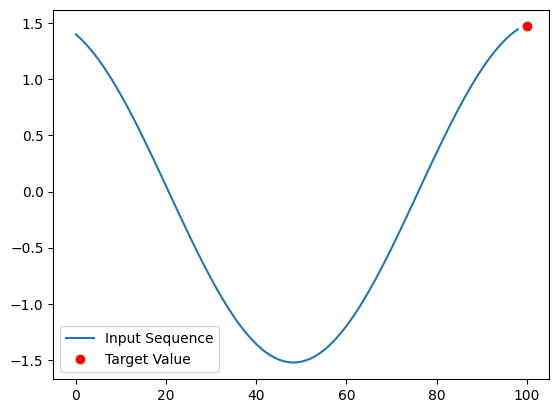

In [263]:
# Generate Sinusoidal Wave Dataset
def generate_sine_wave_data(num_samples, num_timesteps, freq_range, amp_range):
    """
    Generate sine wave data with varying frequencies, amplitudes, and random phase shifts.
    The last value in each sequence is used as the target prediction.

    Parameters:
    - num_samples: Number of samples to generate.
    - num_timesteps: Number of timesteps for each sample.
    - freq_range: Tuple of floor and ceiling of frequency range.
    - amp_range: Tuple of floor and ceiling of amplitude range.

    Returns:
    - X: Generated sine wave data of shape (num_samples, num_timesteps - 1).
    - y: Target values of shape (num_samples,).
    """
    X = np.zeros((num_samples, num_timesteps - 1))
    y = np.zeros(num_samples)
    for i in range(num_samples):
        ### START CODE HERE ###
        # Choose the frequency, amplitude and shift phase value.
        freq = np.random.uniform(freq_range[0], freq_range[1]) #np.random.choice(freq_range)             # Random choose from freq_range.
        amp = np.random.uniform(amp_range[0], amp_range[1]) #np.random.choice(amp_range)              # Random choose from amp_range.
        phase_shift = np.random.uniform(0, 2 * np.pi) #np.random.choice((0,2*np.pi))      # Random choose from (0, 2*pi).
        ### END CODE HERE ###

        t = np.linspace(0, 2 * np.pi, num_timesteps)
        sine_wave = amp * np.sin(freq * t + phase_shift)
        X[i] = sine_wave[:-1]  # All but the last value
        y[i] = sine_wave[-1]   # The last value
    return X, y

### START CODE HERE ###
# You can modify to your preferred range and number of samples. (Note: It's recommended to cover the range of testing data mentioned above.)
num_samples = 10000
num_timesteps = 100
freq_range = (0.5, 5.0)  # Frequency range
amp_range = (0.5, 5.0)   # Amplitude range
### END CODE HERE ###

X, y = generate_sine_wave_data(num_samples, num_timesteps, freq_range, amp_range)

### START CODE HERE ###
# Split data into training and validation sets
split_ratio = 0.8 # 80% to training set
train_size = int(X.shape[0] * split_ratio)
print(train_size)
X_train,y_train = X[:train_size,:],y[:train_size]
X_val,y_val = X[train_size:,:],y[train_size:]
print(f'{X.shape=}, {y.shape=},{X_train.shape=}, {y_train.shape=}, {X_val.shape=}, {y_val.shape=}')
### END CODE HERE ###

# Plot an example sequence
plt.plot(X_train[0], label='Input Sequence')
plt.plot(np.arange(num_timesteps, num_timesteps + 1), y_train[0], 'ro', label='Target Value')
plt.legend()
plt.show()


### Construct the model with Dense layer only
Here, we want you to construct the model with **Dense layer only** like you did in Lab4. You may modify the model structure and parameters in the way you like.

Epoch 1/20: 100%|██████████| 160/160 [00:00<00:00, 1325.51batch/s, loss=0.429]


Epoch 1/20, Training Loss: 0.42947691827311074
Epoch 1/20, Validation Loss: 5.907321652805201e-05


Epoch 2/20: 100%|██████████| 160/160 [00:00<00:00, 3373.34batch/s, loss=4.85e-5]


Epoch 2/20, Training Loss: 4.848596522428655e-05
Epoch 2/20, Validation Loss: 4.82188676293306e-05


Epoch 3/20: 100%|██████████| 160/160 [00:00<00:00, 3646.07batch/s, loss=3.96e-5]


Epoch 3/20, Training Loss: 3.9605047708084924e-05
Epoch 3/20, Validation Loss: 3.936973006003403e-05


Epoch 4/20: 100%|██████████| 160/160 [00:00<00:00, 3509.46batch/s, loss=3.24e-5]


Epoch 4/20, Training Loss: 3.236225995236588e-05
Epoch 4/20, Validation Loss: 3.2155293930048364e-05


Epoch 5/20: 100%|██████████| 160/160 [00:00<00:00, 3357.39batch/s, loss=2.65e-5]


Epoch 5/20, Training Loss: 2.645517843209576e-05
Epoch 5/20, Validation Loss: 2.627349969691169e-05


Epoch 6/20: 100%|██████████| 160/160 [00:00<00:00, 3385.95batch/s, loss=2.16e-5]


Epoch 6/20, Training Loss: 2.163722309838411e-05
Epoch 6/20, Validation Loss: 2.1478092183499224e-05


Epoch 7/20: 100%|██████████| 160/160 [00:00<00:00, 3535.84batch/s, loss=1.77e-5]


Epoch 7/20, Training Loss: 1.770734371697047e-05
Epoch 7/20, Validation Loss: 1.756831138625915e-05


Epoch 8/20: 100%|██████████| 160/160 [00:00<00:00, 3506.47batch/s, loss=1.45e-5]


Epoch 8/20, Training Loss: 1.450161159468211e-05
Epoch 8/20, Validation Loss: 1.4380488061961264e-05


Epoch 9/20: 100%|██████████| 160/160 [00:00<00:00, 3954.72batch/s, loss=1.19e-5]


Epoch 9/20, Training Loss: 1.1886364507466641e-05
Epoch 9/20, Validation Loss: 1.1781192020820444e-05


Epoch 10/20: 100%|██████████| 160/160 [00:00<00:00, 3941.48batch/s, loss=9.75e-6]


Epoch 10/20, Training Loss: 9.752617796893263e-06
Epoch 10/20, Validation Loss: 9.661646177936558e-06


Epoch 11/20: 100%|██████████| 160/160 [00:00<00:00, 4011.36batch/s, loss=8.01e-6]


Epoch 11/20, Training Loss: 8.01150768416359e-06
Epoch 11/20, Validation Loss: 7.933172476661024e-06


Epoch 12/20: 100%|██████████| 160/160 [00:00<00:00, 3851.05batch/s, loss=6.59e-6]


Epoch 12/20, Training Loss: 6.590576103936317e-06
Epoch 12/20, Validation Loss: 6.523479036405767e-06


Epoch 13/20: 100%|██████████| 160/160 [00:00<00:00, 3893.24batch/s, loss=5.43e-6]


Epoch 13/20, Training Loss: 5.43074160855784e-06
Epoch 13/20, Validation Loss: 5.373633115442064e-06


Epoch 14/20: 100%|██████████| 160/160 [00:00<00:00, 3819.17batch/s, loss=4.48e-6]


Epoch 14/20, Training Loss: 4.4838296207137e-06
Epoch 14/20, Validation Loss: 4.435593199098989e-06


Epoch 15/20: 100%|██████████| 160/160 [00:00<00:00, 3828.10batch/s, loss=3.71e-6]


Epoch 15/20, Training Loss: 3.710558727246579e-06
Epoch 15/20, Validation Loss: 3.6701969330348755e-06


Epoch 16/20: 100%|██████████| 160/160 [00:00<00:00, 3726.22batch/s, loss=3.08e-6]


Epoch 16/20, Training Loss: 3.078898792617974e-06
Epoch 16/20, Validation Loss: 3.045520702702276e-06


Epoch 17/20: 100%|██████████| 160/160 [00:00<00:00, 3758.08batch/s, loss=2.56e-6]


Epoch 17/20, Training Loss: 2.562732228417631e-06
Epoch 17/20, Validation Loss: 2.535542214841788e-06


Epoch 18/20: 100%|██████████| 160/160 [00:00<00:00, 2974.16batch/s, loss=2.14e-6]


Epoch 18/20, Training Loss: 2.1407624380792097e-06
Epoch 18/20, Validation Loss: 2.1190501169505426e-06


Epoch 19/20: 100%|██████████| 160/160 [00:00<00:00, 1155.14batch/s, loss=1.8e-6]


Epoch 19/20, Training Loss: 1.795623795274878e-06
Epoch 19/20, Validation Loss: 1.7787550279145017e-06


Epoch 20/20: 100%|██████████| 160/160 [00:00<00:00, 3178.51batch/s, loss=1.51e-6]


Epoch 20/20, Training Loss: 1.5131559435911737e-06
Epoch 20/20, Validation Loss: 1.5005647803496004e-06


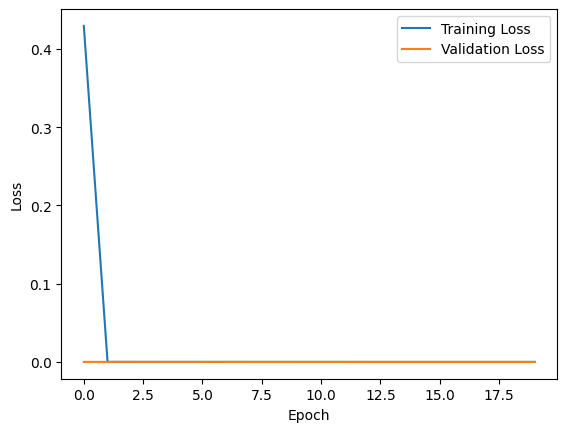

In [252]:
### START CODE HERE ###
# Change the structure and parameters to train your own model (Only contain Dense layer here!!!)
# Reshape the input data to fit Dense model
input_size = X_train.shape[1]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1])
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1])
y_val = y_val.reshape(-1, 1)
y_train = y_train.reshape(-1, 1)
# Construct the model with Dense layers

model = Model()
model.add(Dense(input_size, 64))
model.add(Activation("relu", None))
model.add(Dense(64, 1))
model.add(Activation("linear", None))

# Train the model
model.train(X_train, y_train, X_val, y_val, epochs=20, learning_rate=0.001, batch_size = 8, loss_function='mse')
### END CODE HERE ###

# Plot the training and validation losses
model.plot_losses()

#### Predict testing data & Save the answer (For Dense model)
For this prediction of Dense model, you can choose not to submit it to Kaggle if its performance is not better.

In [253]:
### START CODE HERE ###
# Read the X_test.csv file into a DataFrame
# Change the path if needed
# download
X_test_df = pd.read_csv('Sinewave/X_test.csv')
### END CODE HERE ###

# Do not modify this part to get the correct output format!!
# Drop the 'Id' column if it exists
if 'Id' in X_test_df.columns:
    X_test_df = X_test_df.drop(columns=['Id'])

# Convert the DataFrame to a numpy array
X_test = X_test_df.values
y_pred = model.predict(X_test)


# Convert the list of predictions to a numpy array
y_pred = np.array(y_pred)
y_pred_df = pd.DataFrame(y_pred, columns=['answer'])
y_pred_df.insert(0, 'Id', range(1, 1 + len(y_pred_df)))
y_pred_df.to_csv('y_pred_basic.csv', index=False)

print('Prediction data has been saved.')

Prediction data has been saved.


### Construct the model with RNN layer
Then, we can integrate our custom-built RNN layer into the model to evaluate whether it improves performance on the sequential inputs.

Epoch 1/30: 100%|██████████| 80/80 [00:01<00:00, 46.87batch/s, loss=0.477]


Epoch 1/30, Training Loss: 0.47683170937522
Epoch 1/30, Validation Loss: 0.18407717677264607


Epoch 2/30: 100%|██████████| 80/80 [00:01<00:00, 41.19batch/s, loss=0.165]


Epoch 2/30, Training Loss: 0.16491544154640447
Epoch 2/30, Validation Loss: 0.1514446566861734


Epoch 3/30: 100%|██████████| 80/80 [00:01<00:00, 42.78batch/s, loss=0.139]


Epoch 3/30, Training Loss: 0.13865932179237592
Epoch 3/30, Validation Loss: 0.1301370991144532


Epoch 4/30: 100%|██████████| 80/80 [00:01<00:00, 41.79batch/s, loss=0.12] 


Epoch 4/30, Training Loss: 0.12039452133598882
Epoch 4/30, Validation Loss: 0.11423024831282425


Epoch 5/30: 100%|██████████| 80/80 [00:01<00:00, 40.89batch/s, loss=0.106]


Epoch 5/30, Training Loss: 0.10614239519360127
Epoch 5/30, Validation Loss: 0.10118279547214966


Epoch 6/30: 100%|██████████| 80/80 [00:01<00:00, 44.90batch/s, loss=0.094] 


Epoch 6/30, Training Loss: 0.09403958296697254
Epoch 6/30, Validation Loss: 0.08967080097697652


Epoch 7/30: 100%|██████████| 80/80 [00:01<00:00, 41.95batch/s, loss=0.0831]


Epoch 7/30, Training Loss: 0.0830624490843088
Epoch 7/30, Validation Loss: 0.07892111454797288


Epoch 8/30: 100%|██████████| 80/80 [00:02<00:00, 38.10batch/s, loss=0.0726]


Epoch 8/30, Training Loss: 0.07260278852920467
Epoch 8/30, Validation Loss: 0.06847137926981091


Epoch 9/30: 100%|██████████| 80/80 [00:02<00:00, 38.32batch/s, loss=0.0623]


Epoch 9/30, Training Loss: 0.062315776780502895
Epoch 9/30, Validation Loss: 0.05809014002761637


Epoch 10/30: 100%|██████████| 80/80 [00:02<00:00, 39.47batch/s, loss=0.0521]


Epoch 10/30, Training Loss: 0.05207892844064127
Epoch 10/30, Validation Loss: 0.047768763191286125


Epoch 11/30: 100%|██████████| 80/80 [00:02<00:00, 39.91batch/s, loss=0.042] 


Epoch 11/30, Training Loss: 0.041998624592700776
Epoch 11/30, Validation Loss: 0.03773691499410232


Epoch 12/30: 100%|██████████| 80/80 [00:02<00:00, 39.71batch/s, loss=0.0324]


Epoch 12/30, Training Loss: 0.032415583879055895
Epoch 12/30, Validation Loss: 0.028448303042115042


Epoch 13/30: 100%|██████████| 80/80 [00:02<00:00, 39.81batch/s, loss=0.0239]


Epoch 13/30, Training Loss: 0.023850160973144983
Epoch 13/30, Validation Loss: 0.020474121470529696


Epoch 14/30: 100%|██████████| 80/80 [00:02<00:00, 36.95batch/s, loss=0.0168]


Epoch 14/30, Training Loss: 0.01683900515180882
Epoch 14/30, Validation Loss: 0.014283464660501182


Epoch 15/30: 100%|██████████| 80/80 [00:02<00:00, 37.47batch/s, loss=0.0117]


Epoch 15/30, Training Loss: 0.01169690039417296
Epoch 15/30, Validation Loss: 0.010011298566191488


Epoch 16/30: 100%|██████████| 80/80 [00:02<00:00, 36.57batch/s, loss=0.00836]


Epoch 16/30, Training Loss: 0.00835680720622904
Epoch 16/30, Validation Loss: 0.007398611790891188


Epoch 17/30: 100%|██████████| 80/80 [00:01<00:00, 40.01batch/s, loss=0.00643]


Epoch 17/30, Training Loss: 0.006428486976071344
Epoch 17/30, Validation Loss: 0.005961513116657265


Epoch 18/30: 100%|██████████| 80/80 [00:02<00:00, 39.73batch/s, loss=0.00542]


Epoch 18/30, Training Loss: 0.005418211223810433
Epoch 18/30, Validation Loss: 0.0052266942925527395


Epoch 19/30: 100%|██████████| 80/80 [00:02<00:00, 39.77batch/s, loss=0.00492]


Epoch 19/30, Training Loss: 0.0049190053299225135
Epoch 19/30, Validation Loss: 0.004859298947549836


Epoch 20/30: 100%|██████████| 80/80 [00:02<00:00, 36.11batch/s, loss=0.00467]


Epoch 20/30, Training Loss: 0.004672381348093656
Epoch 20/30, Validation Loss: 0.004667208397402212


Epoch 21/30: 100%|██████████| 80/80 [00:01<00:00, 42.28batch/s, loss=0.00454]


Epoch 21/30, Training Loss: 0.00454068018491226
Epoch 21/30, Validation Loss: 0.004554400977303676


Epoch 22/30: 100%|██████████| 80/80 [00:02<00:00, 38.20batch/s, loss=0.00446]


Epoch 22/30, Training Loss: 0.004458763656067712
Epoch 22/30, Validation Loss: 0.004476843386383475


Epoch 23/30: 100%|██████████| 80/80 [00:02<00:00, 36.05batch/s, loss=0.0044] 


Epoch 23/30, Training Loss: 0.0043980707638980425
Epoch 23/30, Validation Loss: 0.004415279483553168


Epoch 24/30: 100%|██████████| 80/80 [00:01<00:00, 42.65batch/s, loss=0.00435]


Epoch 24/30, Training Loss: 0.004346642413146686
Epoch 24/30, Validation Loss: 0.0043614380244387085


Epoch 25/30: 100%|██████████| 80/80 [00:02<00:00, 35.05batch/s, loss=0.0043] 


Epoch 25/30, Training Loss: 0.0042995908145731865
Epoch 25/30, Validation Loss: 0.004311743347679762


Epoch 26/30: 100%|██████████| 80/80 [00:02<00:00, 35.50batch/s, loss=0.00425]


Epoch 26/30, Training Loss: 0.004254930994502537
Epoch 26/30, Validation Loss: 0.004264604734547771


Epoch 27/30: 100%|██████████| 80/80 [00:02<00:00, 33.44batch/s, loss=0.00421]


Epoch 27/30, Training Loss: 0.00421184653204521
Epoch 27/30, Validation Loss: 0.004219277734148543


Epoch 28/30: 100%|██████████| 80/80 [00:02<00:00, 39.85batch/s, loss=0.00417]


Epoch 28/30, Training Loss: 0.004169987832690307
Epoch 28/30, Validation Loss: 0.004175387897919933


Epoch 29/30: 100%|██████████| 80/80 [00:02<00:00, 38.80batch/s, loss=0.00413]


Epoch 29/30, Training Loss: 0.004129192145595954
Epoch 29/30, Validation Loss: 0.004132729128385001


Epoch 30/30: 100%|██████████| 80/80 [00:02<00:00, 38.10batch/s, loss=0.00409]


Epoch 30/30, Training Loss: 0.004089372414961706
Epoch 30/30, Validation Loss: 0.004091176028276836


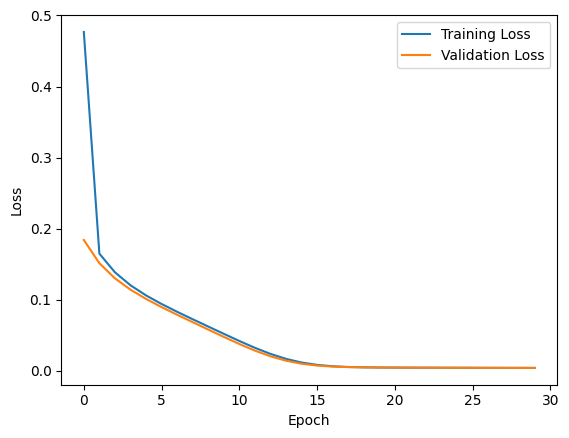

In [271]:
### START CODE HERE ###
# Change the structure and parameters to train your own model (Can add RNN layer here)
# Reshape X_train and X_val to fit the RNN layer input shape.
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
y_val = y_val.reshape(-1, 1)
y_train = y_train.reshape(-1, 1)

# Construct the model & Set the parameters.
input_size = 1  # Number of input features (1 for single sine wave value)
rnn_units = 100  # Number of units in the RNN layer
dense_units = 128  # Number of units in the Dense layer
output_size = 1  # Number of output classes (1 for single sine wave value)

# model = Model()
# print(f'{X_train.shape=},{X_val.shape=},{y_train.shape=}')
model = Model()
model.add(RNN(input_size, rnn_units))
# model.add(RNN(rnn_units, rnn_units))
# model.add(Dense(rnn_units, dense_units))
# model.add(Activation("relu", None))
model.add(Dense(rnn_units, output_size))
model.add(Activation("linear", None))

# Train the model
model.train(X_train, y_train, X_val, y_val, epochs=30, learning_rate=0.01, batch_size = 100, loss_function='mse')
### END CODE HERE ###

# Plot the training and validation losses
model.plot_losses()

#### Predict testing data & Save the answer (For RNN model)
Remember to submit your prediction to Kaggle!

In [272]:
### START CODE HERE ###
# Read the X_test.csv file into a DataFrame
# Change the path if needed
X_test_df = pd.read_csv('Sinewave/X_test.csv')
### END CODE HERE ###


# Do not modify this part to get the correct output format!!
# Drop the 'Id' column if it exists
if 'Id' in X_test_df.columns:
    X_test_df = X_test_df.drop(columns=['Id'])

# Convert the DataFrame to a numpy array
X_test = X_test_df.values
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))  # reshape the X_test to fit RNN layer input shape.
y_pred = model.predict(X_test)


# Convert the list of predictions to a numpy array
y_pred = np.array(y_pred)
y_pred_df = pd.DataFrame(y_pred, columns=['answer'])
y_pred_df.insert(0, 'Id', range(1, 1 + len(y_pred_df)))
y_pred_df.to_csv('y_pred_basic.csv', index=False)

print('Prediction data has been saved.')

Prediction data has been saved.


# Advance part (35%)






## Accelerometer and Gyroscope dataset
- ⚠⚠ You need to download the training & testing data from Kaggle. ⚠⚠ (Put it into the directory name `Activity data`, or your need to change the path in template.)
- In this dataset, we provide the time-series Accelerometer and Gyroscope data each with 3-axial (x, y, z) (total 6 channels).
- We classified the activity into 3 different classes:
    Activity 1, 2, 3\
    You have to build a RNN model using these time-series data to predict the activity class.
- Steps:
    1. Load the provided `X_train.npy`, `y_train.npy` and `X_test.npy` and split the part of training data to validation.\
    Note: `y_train.npy` is already one-hot encoded.
    2. Visualize the `X_train.npy`.
    3. One-hot encode the `y_train.npy` for three classes: Activity 1, Activity 2, Activity 3.
    4. Build your own RNN model and train it.
    5. Predict with the `X_test.npy` and generate `y_test.csv` then **submit it to Kaggle**!
- We have set 3 baselines on public score:
    * Accuracy >= 0.65 -> 10 points
    * Accuracy >= 0.7  -> 20 points
    * Accuracy >= 0.75 -> 25 points
- Kaggle link: https://www.kaggle.com/t/95e0b11f63e74566802b0dea5ec4f1b4


### 1. Load training & testing data
Load the training and testing data, then split the training data into a validation set using your preferred ratio.

In [347]:
### START CODE HERE ###
# Load X_train, y_train and X_test data
# Change the path if needed
y_train = np.load('Activity data/y_train.npy')
X_train = np.load('Activity data/X_train.npy')
m = X_train.shape[0]
permutation = list(np.random.permutation(m))
X_train = X_train[permutation]
y_train = y_train[permutation]

X_test = np.load('Activity data/X_test.npy')
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
### END CODE HERE ###

### START CODE HERE ###
def normalize_data(X):
    # 計算每個特徵軸的均值和標準差
    mean = np.mean(X, axis=(0, 1), keepdims=True)  # 對樣本和時間步計算均值
    std = np.std(X, axis=(0, 1), keepdims=True)    # 對樣本和時間步計算標準差

    # 避免標準差為 0 的情況
    std[std == 0] = 1

    # 標準化數據
    X_normalized = (X - mean) / std
    return X_normalized
# Define the validation ratio in your preferred way
# 1. One-hot encode y_train. (3 classes)
# 2. Split the X_train, y_train data into train & validation set.
# print(y_train)
y_train = np.eye(3)[y_train.flatten()]
validation_ratio = 0.15
total = X_train.shape[0]
val_size = round(validation_ratio * total)
# print(size)
X_val = normalize_data(X_train[-val_size:,:,:])
X_train = normalize_data(X_train[:total - val_size,:,:])
X_test = normalize_data(X_test)
y_val = y_train[-val_size:]
y_train = y_train[:total-val_size]


# print(X_val.shape,X_train.shape)
# X_train = 
### END CODE HERE ###



X_train shape: (7352, 128, 6)
y_train shape: (7352, 1)
X_test shape: (2947, 128, 6)


### 2. Visualize the training data

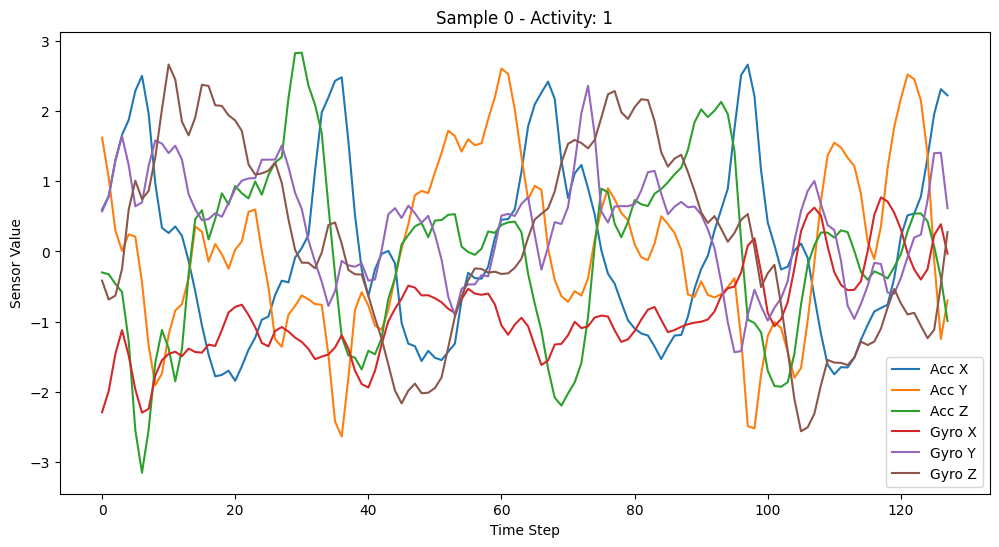

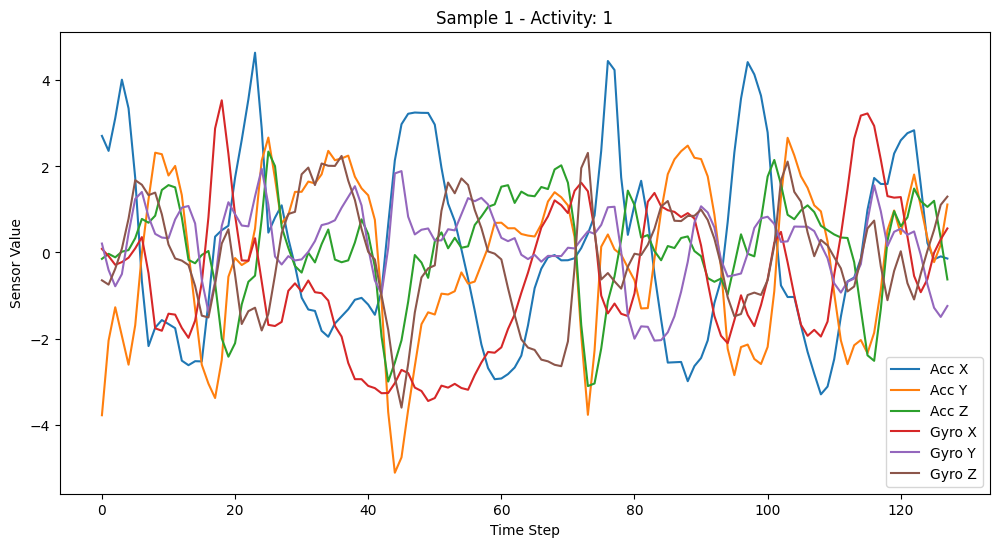

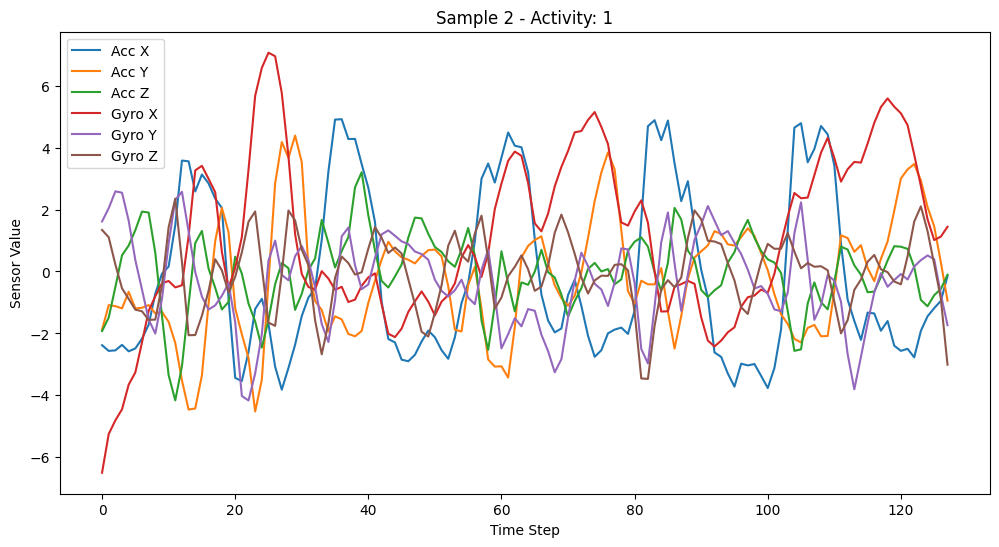

In [348]:
# Function to plot a single sample
def plot_sample(X, y, sample_index):
    plt.figure(figsize=(12, 6))
    plt.plot(X[sample_index, :, 0], label='Acc X')
    plt.plot(X[sample_index, :, 1], label='Acc Y')
    plt.plot(X[sample_index, :, 2], label='Acc Z')
    plt.plot(X[sample_index, :, 3], label='Gyro X')
    plt.plot(X[sample_index, :, 4], label='Gyro Y')
    plt.plot(X[sample_index, :, 5], label='Gyro Z')
    plt.title(f'Sample {sample_index} - Activity: {np.argmax(y[sample_index])}')
    plt.xlabel('Time Step')
    plt.ylabel('Sensor Value')
    plt.legend()
    plt.show()

### START CODE HERE ###
# Plot a few samples
for i in range(3):              # Change the range to visualize more samples
    plot_sample(X_train, y_train, i)
 ### END CODE HERE ###

### 3. Contruct and train the model

Epoch 1/1000, Training Loss: 1.5109333356255896
Epoch 1/1000, Validation Loss: 1.0578834350945463, Learning_rate: 0.001
Epoch 2/1000, Training Loss: 1.4258919612584697
Epoch 2/1000, Validation Loss: 1.0272311156579013, Learning_rate: 0.001
Epoch 3/1000, Training Loss: 1.3669297428118505
Epoch 3/1000, Validation Loss: 1.0071422624986905, Learning_rate: 0.001
Epoch 4/1000, Training Loss: 1.322874123875654
Epoch 4/1000, Validation Loss: 0.9925965035334752, Learning_rate: 0.001
Epoch 5/1000, Training Loss: 1.2885464056083642
Epoch 5/1000, Validation Loss: 0.981376942635053, Learning_rate: 0.001
Epoch 6/1000, Training Loss: 1.2609447784010177
Epoch 6/1000, Validation Loss: 0.9722040130225713, Learning_rate: 0.001
Epoch 7/1000, Training Loss: 1.2382172614340452
Epoch 7/1000, Validation Loss: 0.9643055601549995, Learning_rate: 0.001
Epoch 8/1000, Training Loss: 1.2190642613284082
Epoch 8/1000, Validation Loss: 0.95721120682986, Learning_rate: 0.001
Epoch 9/1000, Training Loss: 1.2025402291453

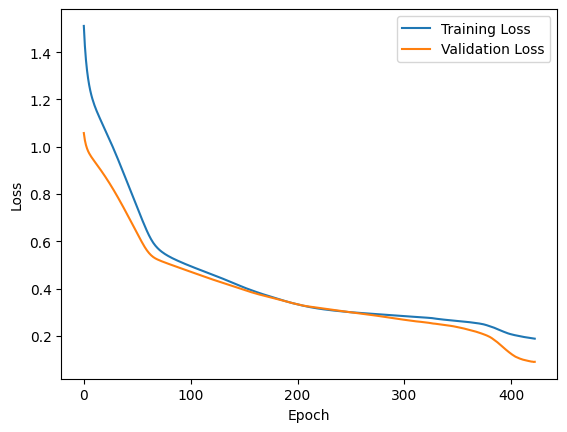

In [386]:
### START CODE HERE ###
# Construct the model & Set the parameters.
input_size = 6  # Number of input features (1 for single sine wave value)
rnn_units = 256  # Number of units in the RNN layer
dense_units = 32  # Number of units in the Dense layer
output_size = 3  # Number of output classes
reduce = False
reduce_rate = 0.5

model = Model()
model.add(RNN(input_size, rnn_units))
# model.add(RNN(rnn_units, rnn_units//2))
model.add(Dense(rnn_units, dense_units))
model.add(Activation("relu", None))
model.add(Dense(dense_units, output_size))
model.add(Activation("softmax", None))
# Train the model
model.train(X_train, y_train, X_val, y_val, epochs=1000, learning_rate=0.001, batch_size = 64, loss_function='cce')

### END CODE HERE ###
# Plot the training and validation losses
model.plot_losses()

### 4. Predict the output and Save it
Remember to submit `y_pred.csv` to Kaggle!

In [388]:
# Do not modify this part to get the correct output format!!
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
# Save the predicted classes to a CSV file
y_pred_df = pd.DataFrame({
    'Id': np.arange(len(y_pred_classes)),
    'Classes': y_pred_classes
})

# Save the DataFrame to a CSV file
y_pred_df.to_csv('y_pred_advanced.csv', index=False)